# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = '/datasets/faces/'
img_path = data_path + 'final_files/'


labels = pd.read_csv(data_path + 'labels.csv')

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

# для обучающих данных
train_generator = datagen.flow_from_dataframe(
dataframe=labels,
directory=img_path,
x_col='file_name',
y_col='real_age',
target_size=(224, 224),
batch_size=32,
class_mode='raw',
subset='training')


Found 5694 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
print('Количество фотографий:', labels.shape[0])

Количество фотографий: 7591


<b>График распределения возраста</b>

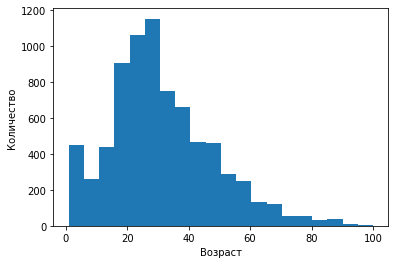

In [6]:
plt.hist(labels['real_age'], bins=20)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

<b>15 фотографий</b>

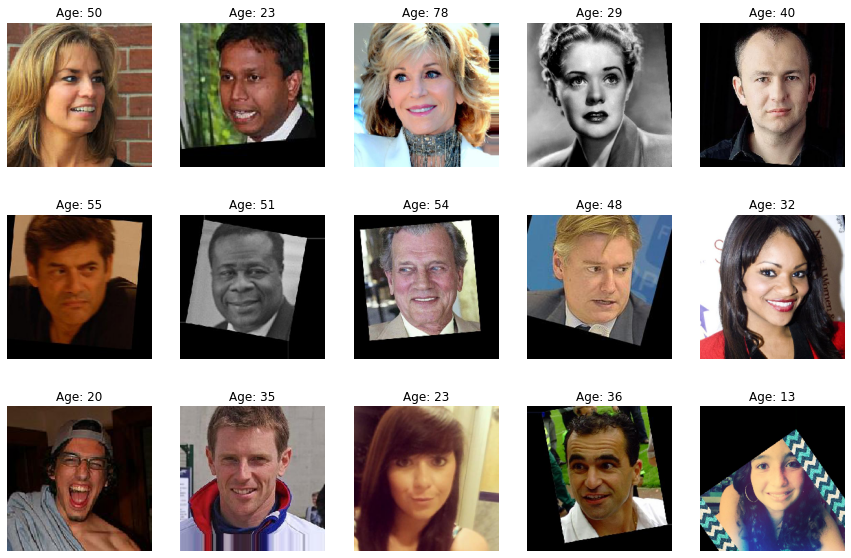

In [7]:
images, labels = next(train_generator)

fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title('Age: ' + str(labels[i]))
    ax.axis('off')

plt.show()

<b>Выводы:</b>
   - Большинство людей в возрасте от 20 до 40 лет
   - Присутствуют фотографии под углом, размытые, ЧБ
   - Большинство фотографий из выборки корректны 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < 
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):


    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

 >

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/5

356/356 - 71s - loss: 223.4963 - mae: 10.7414 - val_loss: 677.1084 - val_mae: 20.9933
Epoch 2/5
356/356 - 45s - loss: 87.1675 - mae: 7.0927 - val_loss: 128.6078 - val_mae: 8.6901
Epoch 3/5
356/356 - 46s - loss: 58.3408 - mae: 5.8623 - val_loss: 88.9718 - val_mae: 7.0530
Epoch 4/5
356/356 - 46s - loss: 44.1607 - mae: 5.1138 - val_loss: 89.5223 - val_mae: 7.0434
Epoch 5/5
356/356 - 44s - loss: 32.4302 - mae: 4.3743 - val_loss: 104.0219 - val_mae: 7.5406
WARNING:tensorflow:sample_weight modes were coerced from

119/119 - 10s - loss: 104.0219 - mae: 7.5406
Test MAE: 7.5406

```

## Анализ обученной модели

<b>Вывод:</b>
   - Выбрана свёрточная сеть ResNet50
   - За 5 эпох mae уменьшилось с 10.77 до 4.33
   - ошибка на тестовой выборке составила 7.54 
   - Погрешность в 7 лет для бизнеса не является значительной